In [5]:
using ProgressMeter, PyCall, PyPlot, Images, HDF5,NaNStatistics, Statistics
using _Data

In [67]:
@pyimport scipy.ndimage as ndimage
@pyimport numpy as np

In [6]:
experimenter = "dogus"

"dogus"

In [47]:
bg_filename = "20240517_135803"
server = 1
ds_bg = Dataset(bg_filename, experimenter, gethostname() == "roli-$(server)" ? "/data" : "/nfs/data$(server)")
reader_bg = Reader(ds_bg, :img_bg)

Reader{0x000014d0, 0x00001200, 0x0000000000000001, 0x00000014, 0x00000012, 0x00000100, 0x00000100, 0x000001d0, 0x00000100}(TiledCompressor{0x00000014, 0x00000012, 0x00000100, 0x00000100, 0x000001d0, 0x00000100}(_Data.Compression.Compressor{0x00000100, 0x00000100}(_Data.Compression.Decorrelator{0x00000100, 0x00000100}(), UInt16[0x0000 0x0000 ‚Ä¶ 0x0000 0x0000; 0x0000 0x0000 ‚Ä¶ 0x0000 0x0000; ‚Ä¶ ; 0x0000 0x0000 ‚Ä¶ 0x0000 0x0000; 0x0000 0x0000 ‚Ä¶ 0x0000 0x0000], UInt16[0x0000 0x0000 ‚Ä¶ 0x0000 0x0000; 0x0000 0x0000 ‚Ä¶ 0x0000 0x0000; ‚Ä¶ ; 0x0000 0x0000 ‚Ä¶ 0x0000 0x0000; 0x0000 0x0000 ‚Ä¶ 0x0000 0x0000], UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00  ‚Ä¶  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00]), _Data.Compression.Compressor{0x000001d0, 0x00000100}(_Data.Compression.Decorrelator{0x000001d0, 0x00000100}(), UInt16[0x0000 0x0000 ‚Ä¶ 0x0000 0x0000; 0x0000 0x0000 ‚Ä¶ 0x0000 0x0000; ‚Ä¶ ; 0x0000 0x0000 ‚Ä¶ 0x0000 0x0000; 0x0000 0x0000 ‚Ä¶ 0x0000 0x000

In [48]:
img_bg_all = read(reader_bg, 1);

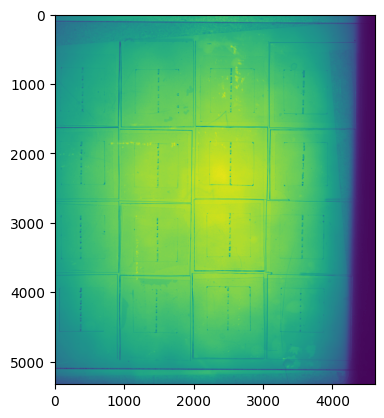

PyObject <matplotlib.image.AxesImage object at 0x754432763f70>

In [49]:
imshow(img_bg_all)

In [1]:
function solve_geometry(x_fish, y_fish, C, img_bg;method="trajectory",background_threshold_low=0,background_threshold_high=250)
    if method == "trajectory"
        xy_projection = zeros(size(img_bg[:,:,end])); 

        for i = findall(C.>0.4)
        # for i = 1:length(x_fish)

            x = round.(Int64, x_fish[i])
            y = round.(Int64, y_fish[i])
            xy_projection[x, y] = 1;
        end

        œÉ = 3.0f0
        kern_œÉ = KernelFactors.gaussian((œÉ, œÉ))
        img_xy = imfilter(xy_projection, kern_œÉ);
        img_xy = (img_xy.>0);
    else
        img_bg_end = img_bg[:,:,end];
        l = size(img_bg_end)[1]
        w = size(img_bg_end)[2]


        figure()
        img_hist(img_bg_end, th_l=0, th_h=500, bins=200);


        #assumption 1: chamber size larger than 100000
        #assumption 2: no attachment to the edge
        #assumption 3: center closest the image center


        minimim_component_size = 10000

        img_xy = (img_bg_end .< background_threshold_high) .* (img_bg_end .> background_threshold_low); 
        img_xy .= erode(img_xy);
    end
    figure()
    imshow(img_xy)
    img_label = label_components(img_xy);
    img_bg_label_area = component_lengths(img_label)
    # candidate_roi_idx = (findall(img_bg_label_area .> 100000).-1); #julia1.7
    candidate_roi_idx = (findall(img_bg_label_area .> 100000));
    edge_covering = zeros(length(candidate_roi_idx))
    for (index, i) in enumerate(candidate_roi_idx)
        roi = (img_label .== i)
        edge_covering[index] = sum(roi[1,:])+sum(roi[end,:])+sum(roi[:,1])+sum(roi[:,end])
    end
    roi_idx = candidate_roi_idx[edge_covering.==minimum(edge_covering)];
    
    println(roi_idx)

    chamber_roi = (img_label .== roi_idx);

    for i = 1:3
        chamber_roi .= dilate(closing(chamber_roi))
        # fig, ax = PyPlot.subplots(1,1)
        # ax.imshow(chamber_roi)
    end
    

    #find countour and center
    countour = find_contours(chamber_roi)[1];
    countour_array = hcat(getindex.(countour, 1), getindex.(countour,2));
    center_loc = mean(countour_array, dims=1);
    BoolBorder = zeros(Int64, size(chamber_roi));
    for ind in countour
        BoolBorder[ind] = 1
    end

    chamber_roi = convert(Array{Int64}, chamber_roi);
    
    chamber_roi = ndimage.binary_fill_holes(BoolBorder)
    chamber_roi = convert(Array{Int64}, chamber_roi)
    
    figure()
    imshow(chamber_roi')
    scatter(center_loc[1], center_loc[2], color="r", s=10)
    
    chamber_roi_xy = findall(chamber_roi.!=0)
    chamber_roi_x = [xy[1] for xy in chamber_roi_xy][1:1000:end]
    chamber_roi_y = [xy[2] for xy in chamber_roi_xy][1:1000:end];
    return countour_array, center_loc,chamber_roi, chamber_roi_x, chamber_roi_y
end


solve_geometry (generic function with 1 method)

In [9]:

"""
Functions for detecting the edges
"""
function find_contours(image)
    nbd = 1
    lnbd = 1
    image = Float64.(image)
    contour_list =  Vector{typeof(CartesianIndex[])}()
    done = [false, false, false, false, false, false, false, false]

    # Clockwise Moore neighborhood.
    dir_delta = [CartesianIndex(-1, 0) , CartesianIndex(-1, 1), CartesianIndex(0, 1), CartesianIndex(1, 1), CartesianIndex(1, 0), CartesianIndex(1, -1), CartesianIndex(0, -1), CartesianIndex(-1,-1)]

    height, width = size(image)

    for i=1:height
        lnbd = 1
        for j=1:width
            fji = image[i, j]
            is_outer = (image[i, j] == 1 && (j == 1 || image[i, j-1] == 0)) ## 1 (a)
            is_hole = (image[i, j] >= 1 && (j == width || image[i, j+1] == 0))

            if is_outer || is_hole
                # 2
                border = CartesianIndex[]

                from = CartesianIndex(i, j)

                if is_outer
                    nbd += 1
                    from -= CartesianIndex(0, 1)

                else
                    nbd += 1
                    if fji > 1
                        lnbd = fji
                    end
                    from += CartesianIndex(0, 1)
                end

                p0 = CartesianIndex(i,j)
                detect_move(image, p0, from, nbd, border, done, dir_delta) ## 3
                if isempty(border) ##TODO
                    push!(border, p0)
                    image[p0] = -nbd
                end
                push!(contour_list, border)
            end
            if fji != 0 && fji != 1
                lnbd = abs(fji)
            end

        end
    end

    return contour_list
end

function detect_move(image, p0, p2, nbd, border, done, dir_delta)
    dir = from_to(p0, p2, dir_delta)
    moved = clockwise(dir)
    p1 = CartesianIndex(0, 0)
    while moved != dir ## 3.1
        newp = move(p0, image, moved, dir_delta)
        if newp[1]!=0
            p1 = newp
            break
        end
        moved = clockwise(moved)
    end

    if p1 == CartesianIndex(0, 0)
        return
    end

    p2 = p1 ## 3.2
    p3 = p0 ## 3.2
    done .= false
    while true
        dir = from_to(p3, p2, dir_delta)
        moved = counterclockwise(dir)
        p4 = CartesianIndex(0, 0)
        done .= false
        while true ## 3.3
            p4 = move(p3, image, moved, dir_delta)
            if p4[1] != 0
                break
            end
            done[moved] = true
            moved = counterclockwise(moved)
        end
        push!(border, p3) ## 3.4
        if p3[1] == size(image, 1) || done[3]
            image[p3] = -nbd
        elseif image[p3] == 1
            image[p3] = nbd
        end

        if (p4 == p0 && p3 == p1) ## 3.5
            break
        end
        p2 = p3
        p3 = p4
    end
end

function clockwise(dir)
    return (dir)%8 + 1
end

# rotate direction counterclocwise
function counterclockwise(dir)
    return (dir+6)%8 + 1
end

# move from current pixel to next in given direction
function move(pixel, image, dir, dir_delta)
    newp = pixel + dir_delta[dir]
    height, width = size(image)
    if (0 < newp[1] <= height) &&  (0 < newp[2] <= width)
        if image[newp]!=0
            return newp
        end
    end
    return CartesianIndex(0, 0)
end

# finds direction between two given pixels
function from_to(from, to, dir_delta)
    delta = to-from
    return findall(x->x == delta, dir_delta)[1]
end


from_to (generic function with 1 method)

In [15]:
data_list = ["20240517_135803", "20240517_150733", "20240517_161442", "20240517_172238", "20240517_182935"]

5-element Vector{String}:
 "20240517_135803"
 "20240517_150733"
 "20240517_161442"
 "20240517_172238"
 "20240517_182935"

In [39]:
h5open(ds_bg, "behavior_$(nr_fish).h5"; raw = true)

üóÇÔ∏è HDF5.File: (read-only) /data/dogus/data_raw/20240517_182935/behavior_3.h5
‚îú‚îÄ üî¢ C
‚îú‚îÄ üî¢ arena_offset_x
‚îú‚îÄ üî¢ arena_offset_y
‚îú‚îÄ üî¢ behavior_frame_index
‚îú‚îÄ üî¢ camera_frame_index
‚îú‚îÄ üî¢ fish_anchor_x
‚îú‚îÄ üî¢ fish_anchor_y
‚îú‚îÄ üî¢ heading
‚îú‚îÄ üî¢ img_bg
‚îú‚îÄ üî¢ img_bg_frame
‚îú‚îÄ üî¢ offset_x
‚îú‚îÄ üî¢ offset_y
‚îú‚îÄ üî¢ pwm_ch0_duty_cycle
‚îú‚îÄ üî¢ pwm_ch0_duty_cycle_keys
‚îú‚îÄ üî¢ pwm_ch0_duty_cycle_values
‚îú‚îÄ üî¢ pwm_ch0_name
‚îú‚îÄ üî¢ pwm_ch1_duty_cycle
‚îú‚îÄ üî¢ pwm_ch1_duty_cycle_keys
‚îú‚îÄ üî¢ pwm_ch1_duty_cycle_values
‚îú‚îÄ üî¢ pwm_ch1_name
‚îú‚îÄ üî¢ temp2_deg
‚îú‚îÄ üî¢ temp_deg
‚îú‚îÄ üî¢ template
‚îú‚îÄ üî¢ template_frame
‚îú‚îÄ üî¢ template_heading
‚îî‚îÄ üî¢ user_event_frame

In [43]:
arena_offset_x_all = []
arena_offset_y_all = []

for nr_fish = 0:15


    bg_filename = data_list[1]
    
    ds_bg = Dataset(bg_filename, experimenter, gethostname() == "roli-$(server)" ? "/data" : "/nfs/data$(server)")
    
    
    arena_offset_x, arena_offset_y = h5open(ds_bg, "behavior_$(nr_fish).h5"; raw = true) do file
        read(file, "arena_offset_x"),
        read(file, "arena_offset_y")
    end;
    
    append!(arena_offset_y_all, arena_offset_y)
    append!(arena_offset_x_all, arena_offset_x)

end

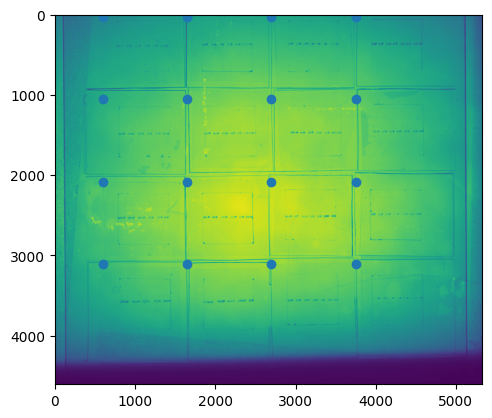

PyObject <matplotlib.collections.PathCollection object at 0x754432bbac50>

In [52]:
imshow(img_bg_all')
scatter(arena_offset_x_all, arena_offset_y_all)

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]


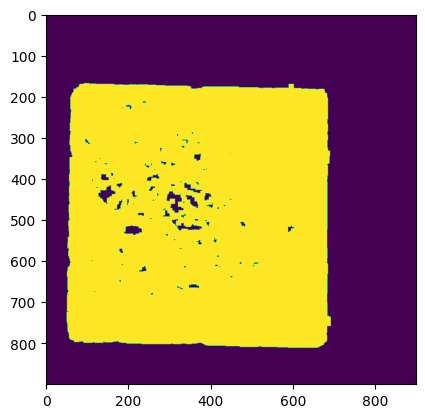

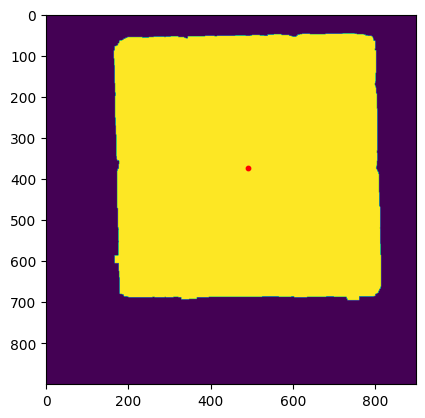

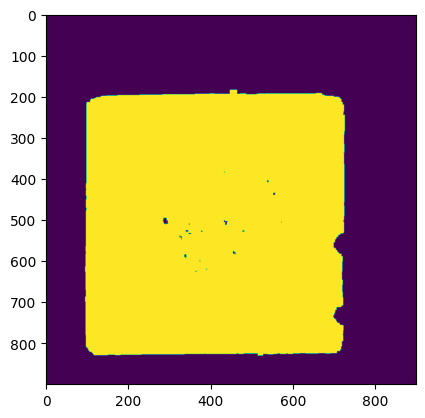

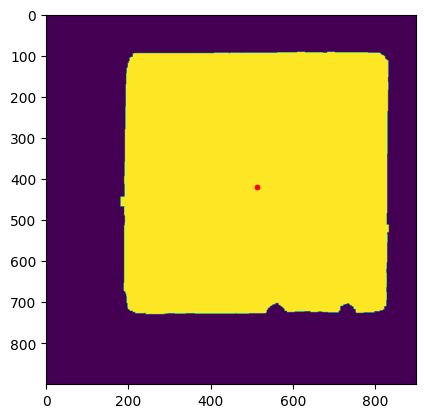

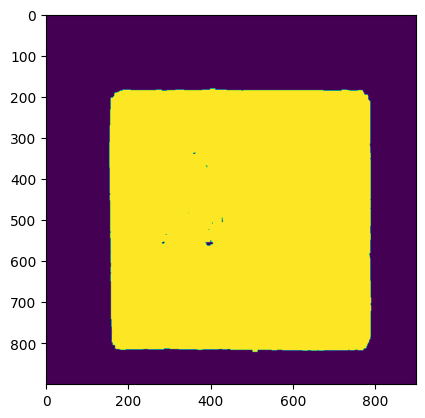

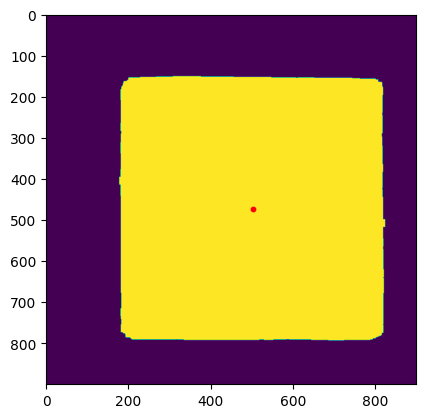

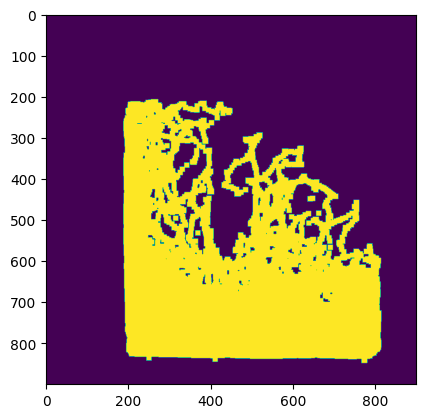

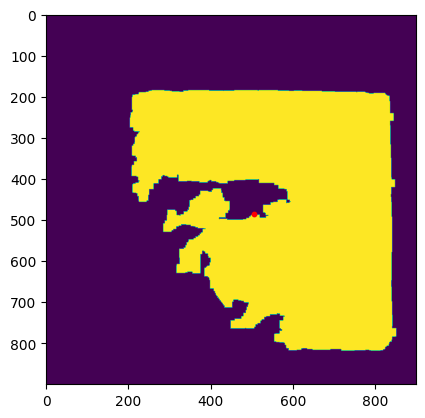

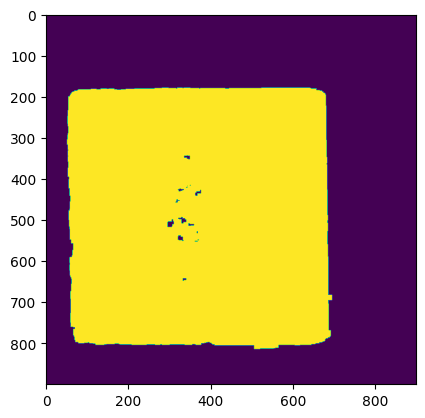

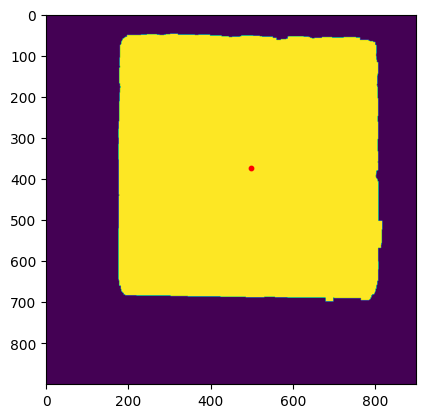

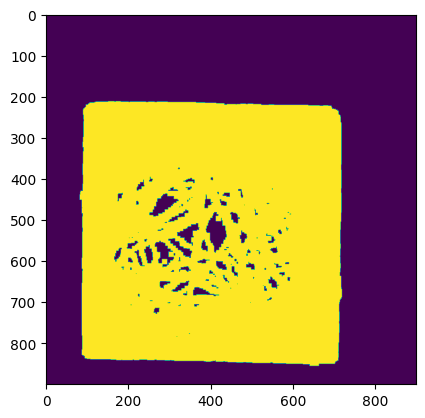

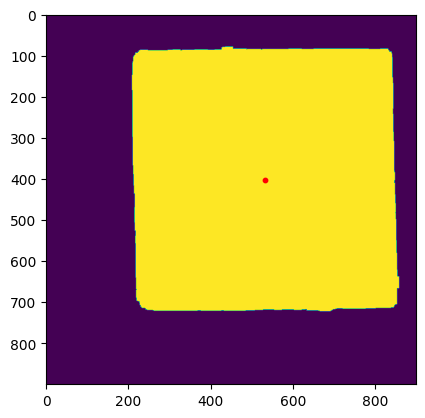

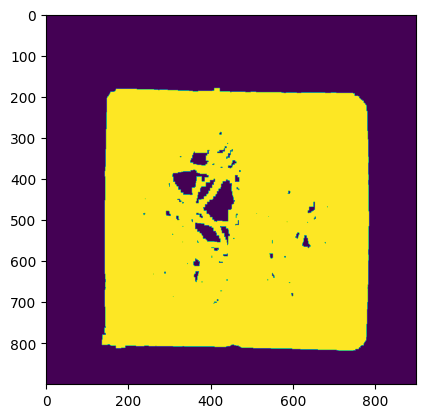

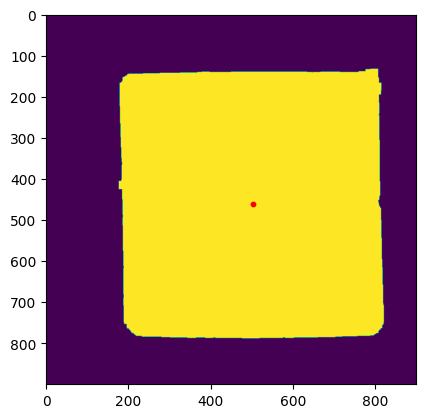

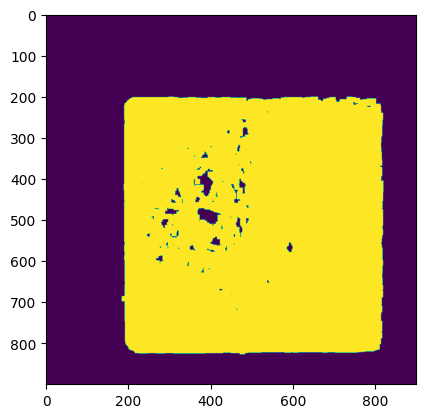

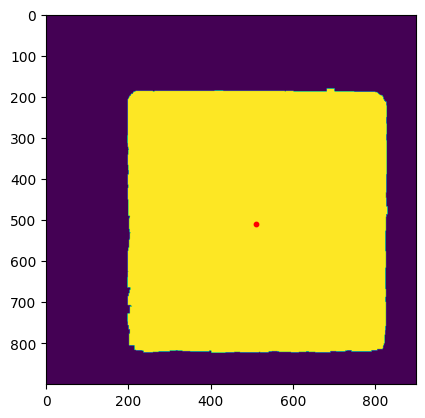

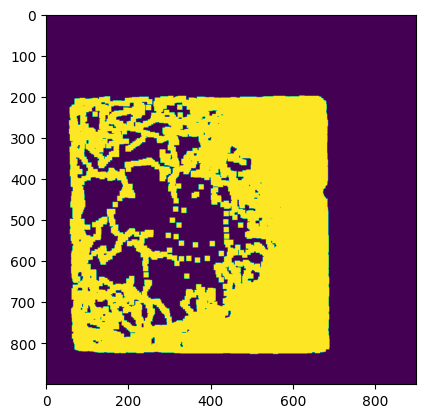

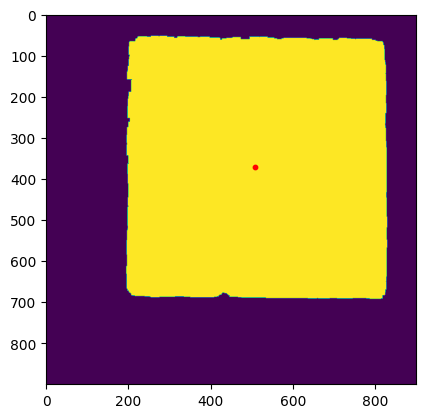

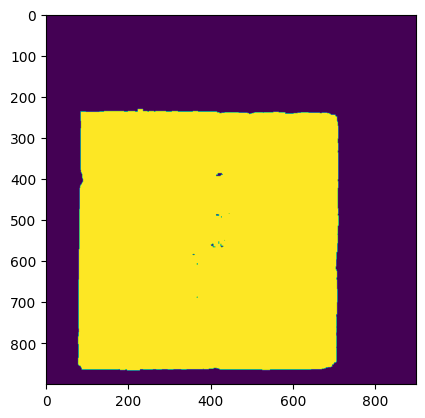

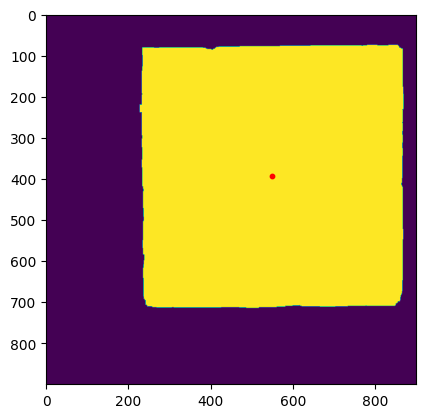

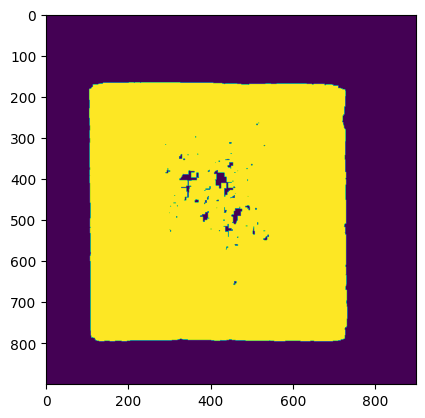

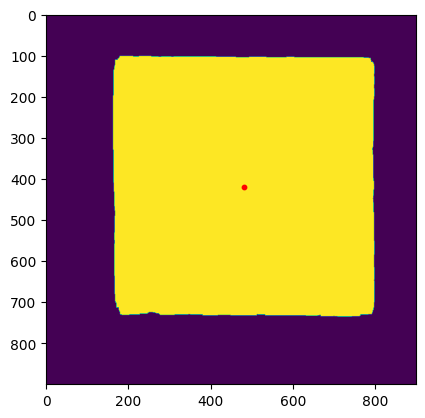

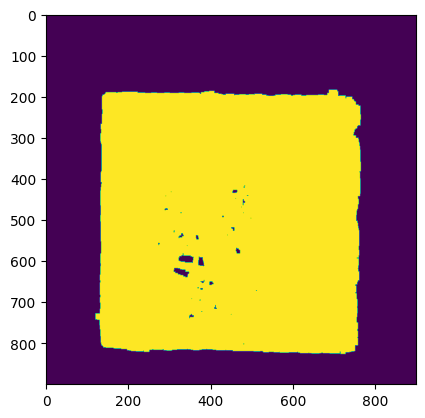

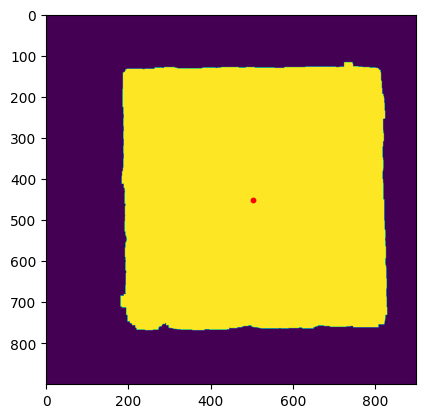

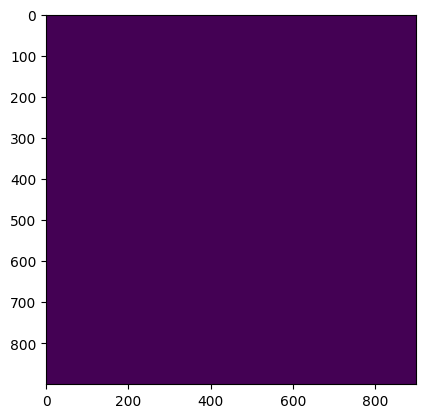

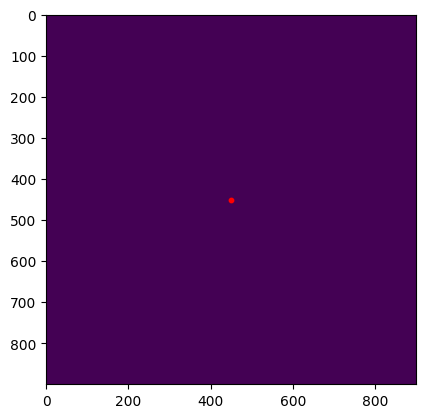

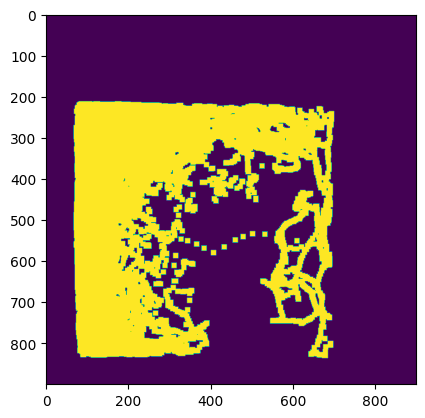

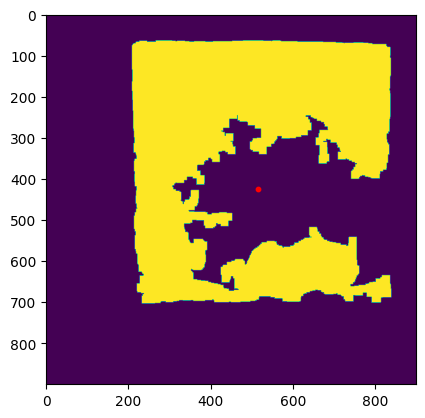

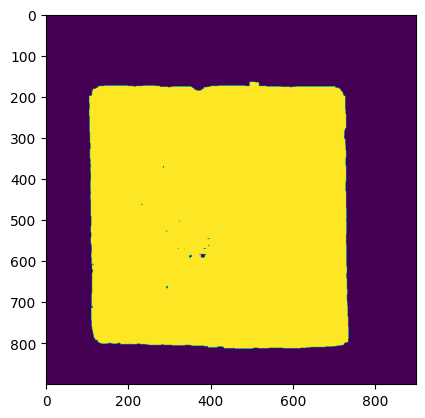

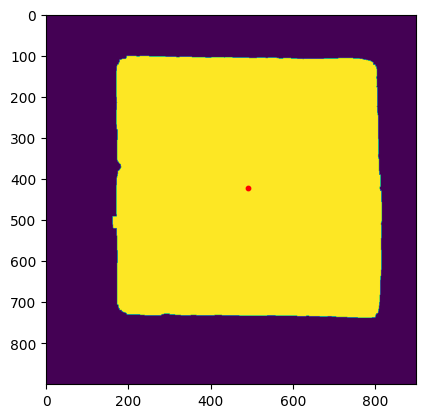

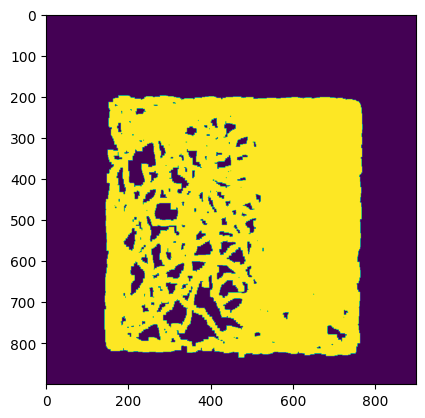

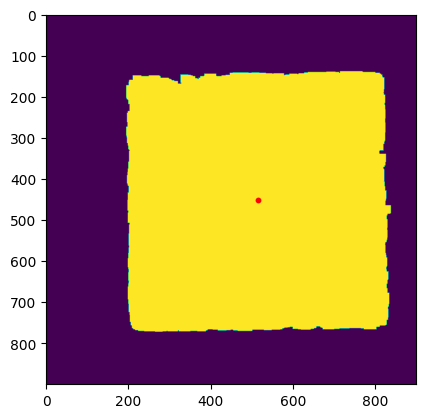

In [83]:
center_loc_all = []
chamber_roi_all = []
countour_array_all = []

for nr_fish = 0:15

C = []
heading = []
y_fish = []
x_fish = []

for bg_filename in data_list

    ds_bg = Dataset(bg_filename, experimenter, gethostname() == "roli-$(server)" ? "/data" : "/nfs/data$(server)")
    
    
    C_, heading_, img_bg, y_fish_, x_fish_ = h5open(ds_bg, "behavior_$(nr_fish).h5"; raw = true) do file
        read(file, "C"),
        read(file, "heading"), 
        read(file, "img_bg"),
        read(file, "fish_anchor_y"), 
        read(file, "fish_anchor_x")
    end;

    append!(C, C_)
    append!(heading, heading_)
    append!(y_fish, y_fish_)
    append!(x_fish, x_fish_)
    

end

countour_array, center_loc,chamber_roi, chamber_roi_x, chamber_roi_y = solve_geometry(x_fish, y_fish, C, img_bg;method="trajectory");


append!(center_loc_all, [center_loc])
append!(chamber_roi_all, [chamber_roi])
append!(countour_array_all, [countour_array])
end

In [74]:
center_loc_xy = reduce(vcat, center_loc_all);

chamber_roi_array = np.array(chamber_roi_all);

countour_array = np.array(countour_array_all)

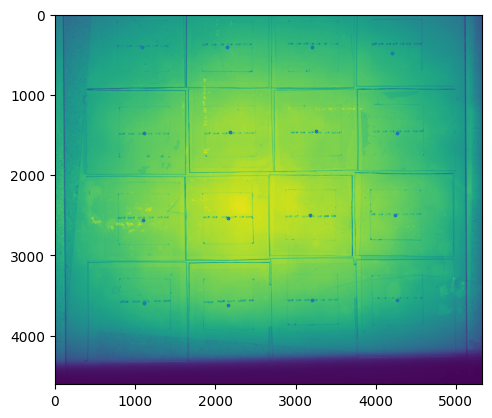

PyObject <matplotlib.collections.PathCollection object at 0x754548479180>

In [63]:
imshow(img_bg_all')
scatter(arena_offset_x_all.+ center_loc_xy[:,1], arena_offset_y_all.+ center_loc_xy[:,2], s =3)

In [80]:
ds_calibration_save = Dataset("20240517_135803", "chuyu", gethostname() == "roli-$(server)" ? "/data" : "/nfs/data$(server)")
mkpath(data_path(ds_calibration_save))

h5open(joinpath(data_path(ds_calibration_save), "image_bg_all_fish.h5"), "w") do file
    file["center_loc_xy"] = center_loc_xy
    file["arena_offset_xy"] = hcat(arena_offset_x_all, arena_offset_y_all)
    file["img_bg_all"] = img_bg_all
    file["chamber_roi_array"] = chamber_roi_array
end;

In [82]:
joinpath(data_path(ds_calibration_save), "image_bg_all_fish.h5")

"/data/chuyu/data/20240517_135803/image_bg_all_fish.h5"